In [1]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2024-02-27 18:21:48.660637


### Introduction to Convolutional Neural Networks and Computer Vision with Tensorflow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front. 

#### Get Data

The images we're working with are from Food101 dataset (101 different classes of food):
https://www.kaggle.com/datasets/dansbecker/food-101

Note: We start with a smaller dataset so we can experiment quickly and figure what works
(or better yet what doesn't work) before scaling up.


In [2]:
## Download:
# https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

### Inspect the data

A very crucial step at the beginning of any machine learning project is becoming 
one with the data. And for a computer vision project... this usually means visualizing 
many samples of your data.

In [3]:
import os
import matplotlib.pyplot as plt

# walk through pizza_steak and list number of files

for dirpath, dirnames, filenames in os.walk("../datasets/pizza_steak/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '../datasets/pizza_steak/'.
There are 2 directories and 0 images in '../datasets/pizza_steak/test'.
There are 0 directories and 250 images in '../datasets/pizza_steak/test/steak'.
There are 0 directories and 250 images in '../datasets/pizza_steak/test/pizza'.
There are 2 directories and 0 images in '../datasets/pizza_steak/train'.
There are 0 directories and 750 images in '../datasets/pizza_steak/train/steak'.
There are 0 directories and 750 images in '../datasets/pizza_steak/train/pizza'.


In [4]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("../datasets/pizza_steak/train/steak"))

num_steak_images_train

750

In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("../datasets/pizza_steak/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [6]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [7]:
# View a random image from the training dataset
img = view_random_image(target_dir="../datasets/pizza_steak/train/",
                        target_class="steak")

Image shape: (512, 512, 3)


After going through a dozen or so images from the different classes, you can start to get an idea of what we're working with.

The entire Food101 dataset comprises of similar images from 101 different classes.

You might've noticed we've been printing the image shape alongside the plotted image.

This is because the way our computer sees the image is in the form of a big array (tensor).

In [8]:
# View the img (actually just a big array/tensor)
img

array([[[186, 186, 188],
        [186, 186, 188],
        [187, 187, 189],
        ...,
        [  2,   4,   1],
        [  2,   4,   1],
        [  2,   4,   1]],

       [[187, 187, 189],
        [187, 187, 189],
        [188, 188, 190],
        ...,
        [  2,   4,   1],
        [  2,   4,   1],
        [  2,   4,   1]],

       [[188, 188, 190],
        [188, 188, 190],
        [189, 189, 191],
        ...,
        [  2,   4,   1],
        [  2,   4,   1],
        [  2,   4,   1]],

       ...,

       [[195, 190, 187],
        [196, 191, 188],
        [196, 191, 188],
        ...,
        [ 91,  89,  90],
        [ 90,  88,  89],
        [ 89,  87,  88]],

       [[195, 190, 187],
        [195, 190, 187],
        [196, 191, 188],
        ...,
        [ 90,  88,  89],
        [ 89,  87,  88],
        [ 88,  86,  87]],

       [[195, 190, 187],
        [196, 191, 188],
        [197, 192, 189],
        ...,
        [ 90,  88,  89],
        [ 88,  86,  87],
        [ 86,  84,  85]]

In [9]:
# View the image shape
img.shape # returns (width, height, colour channels)

(512, 512, 3)

Looking at the image shape more closely, you'll see it's in the form (Width, Height, Colour Channels).

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of red, green and blue (RGB) pixels.

You'll notice all of the values in the img array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value red=0, green=0, blue=255 will look very blue.

So when we build a model to differentiate between our images of pizza and steak, it will be finding patterns in these different pixel values which determine what each class looks like.

🔑 Note: As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255.

In [10]:
# Get all the pixel values between 0 & 1
img/255. 

array([[[0.72941176, 0.72941176, 0.7372549 ],
        [0.72941176, 0.72941176, 0.7372549 ],
        [0.73333333, 0.73333333, 0.74117647],
        ...,
        [0.00784314, 0.01568627, 0.00392157],
        [0.00784314, 0.01568627, 0.00392157],
        [0.00784314, 0.01568627, 0.00392157]],

       [[0.73333333, 0.73333333, 0.74117647],
        [0.73333333, 0.73333333, 0.74117647],
        [0.7372549 , 0.7372549 , 0.74509804],
        ...,
        [0.00784314, 0.01568627, 0.00392157],
        [0.00784314, 0.01568627, 0.00392157],
        [0.00784314, 0.01568627, 0.00392157]],

       [[0.7372549 , 0.7372549 , 0.74509804],
        [0.7372549 , 0.7372549 , 0.74509804],
        [0.74117647, 0.74117647, 0.74901961],
        ...,
        [0.00784314, 0.01568627, 0.00392157],
        [0.00784314, 0.01568627, 0.00392157],
        [0.00784314, 0.01568627, 0.00392157]],

       ...,

       [[0.76470588, 0.74509804, 0.73333333],
        [0.76862745, 0.74901961, 0.7372549 ],
        [0.76862745, 0

In [11]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-02-27 18:21:51.331322: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 18:21:51.331372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 18:21:51.338472: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 18:21:51.379325: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2024-02-27 18:21:58.044963: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 18:21:58.140523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 18:21:58.140856: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4166713750756391401
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2810249216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14057551338418065817
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 750 Ti, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


2024-02-27 18:21:58.162855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 18:21:58.163115: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 18:21:58.163303: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:


tf.constant(img)

2024-02-27 18:21:58.300597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 18:21:58.301087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 18:21:58.301339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[186, 186, 188],
        [186, 186, 188],
        [187, 187, 189],
        ...,
        [  2,   4,   1],
        [  2,   4,   1],
        [  2,   4,   1]],

       [[187, 187, 189],
        [187, 187, 189],
        [188, 188, 190],
        ...,
        [  2,   4,   1],
        [  2,   4,   1],
        [  2,   4,   1]],

       [[188, 188, 190],
        [188, 188, 190],
        [189, 189, 191],
        ...,
        [  2,   4,   1],
        [  2,   4,   1],
        [  2,   4,   1]],

       ...,

       [[195, 190, 187],
        [196, 191, 188],
        [196, 191, 188],
        ...,
        [ 91,  89,  90],
        [ 90,  88,  89],
        [ 89,  87,  88]],

       [[195, 190, 187],
        [195, 190, 187],
        [196, 191, 188],
        ...,
        [ 90,  88,  89],
        [ 89,  87,  88],
        [ 88,  86,  87]],

       [[195, 190, 187],
        [196, 191, 188],
        [197, 192, 189],
        ...,
        [ 90,  88,  8

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "../datasets/pizza_steak/train/"
test_dir  = "../datasets/pizza_steak/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Epoch 1/5


2024-02-27 18:22:02.708366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-02-27 18:22:02.831631: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-27 18:22:05.236620: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-27 18:22:06.095294: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe3f836c8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-27 18:22:06.095690: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 750 Ti, Compute Capability 5.0
2024-02-27 18:22:06.104169: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709068926.308583  249559 device_compile

47/47 [==============================] - 30s 389ms/step - loss: 0.5708 - accuracy: 0.6840 - val_loss: 0.3925 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 14s 285ms/step - loss: 0.4364 - accuracy: 0.7960 - val_loss: 0.3427 - val_accuracy: 0.8620
Epoch 3/5
47/47 [==============================] - 11s 235ms/step - loss: 0.3904 - accuracy: 0.8233 - val_loss: 0.4377 - val_accuracy: 0.7780
Epoch 4/5
47/47 [==============================] - 13s 264ms/step - loss: 0.3715 - accuracy: 0.8353 - val_loss: 0.3149 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 12s 254ms/step - loss: 0.3181 - accuracy: 0.8667 - val_loss: 0.4682 - val_accuracy: 0.7740


In [15]:
# Check out the layers in our model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

In [16]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 13s 212ms/step - loss: 0.6944 - accuracy: 0.4953 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 10s 217ms/step - loss: 0.6928 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 9s 198ms/step - loss: 0.6927 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 10s 217ms/step - loss: 0.6927 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 9s 200ms/step - loss: 0.6927 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000


In [17]:
# Check out our second model's architecture
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
model_3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 15s 240ms/step - loss: 3.3215 - accuracy: 0.6013 - val_loss: 1.0983 - val_accuracy: 0.7240
Epoch 2/5
47/47 [==============================] - 11s 244ms/step - loss: 0.9331 - accuracy: 0.7207 - val_loss: 0.5411 - val_accuracy: 0.7600
Epoch 3/5
47/47 [==============================] - 12s 253ms/step - loss: 0.5116 - accuracy: 0.7820 - val_loss: 0.6188 - val_accuracy: 0.7020
Epoch 4/5
47/47 [==============================] - 9s 198ms/step - loss: 0.5163 - accuracy: 0.7567 - val_loss: 0.4226 - val_accuracy: 0.7860
Epoch 5/5
47/47 [==============================] - 10s 212ms/step - loss: 0.4493 - accuracy: 0.8053 - val_loss: 0.4953 - val_accuracy: 0.7400


In [19]:
# Check out model_3 architecture
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It got ~70% accuracy on the training set and ~70% accuracy on the validation set.

My gosh, the number of trainable parameters has increased even more than model_2. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, model_3 still doesn't out perform model_1.

<mark>This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.</mark>

Image shape: (512, 384, 3)
Image shape: (384, 512, 3)


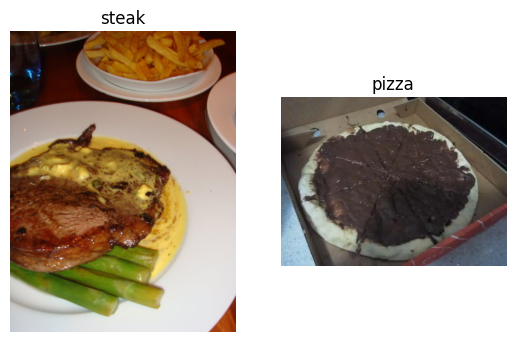

In [20]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("../datasets/pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("../datasets/pizza_steak/train/", "pizza")

### Preprocess the data (prepare it for a model)

In [22]:
# Define training and test directory paths
train_dir = "../datasets/pizza_steak/train/"
test_dir = "../datasets/pizza_steak/test/"

Our next step is to turn our data into batches.

A batch is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

In [23]:
# Create train and test data generators and rescale the data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [24]:
# Turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [26]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [28]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

In [29]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### Create a model (start with a baseline)

You might be wondering what your default model architecture should be.

And the truth is, there's many possible answers to this question.

A simple heuristic for computer vision models is to use the model architecture which is performing best on ImageNet (a large collection of diverse images to benchmark different computer vision models).

However, to begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

**Note**: In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In our case, let's take a smaller version of the model that can be found on the CNN explainer website (model_1 from above) and build a 3 layer convolutional neural network.

In [30]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [32]:
# Create the model (this can be our baseline, a 3 layer Convolutional Neural Network)
model_4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

Great! We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

In [33]:

# Compile the model
model_4.compile(loss='binary_crossentropy', # it was mult-iclass
                optimizer=Adam(),
                metrics=['accuracy'])

### Fit a model

You'll notice two new parameters here:

- steps_per_epoch - this is the number of batches a model will go through per epoch, in our case, we want our model to go through all batches so it's equal to the length of train_data (1500 images in batches of 32 = 1500/32 = ~47 steps)

- validation_steps - same as above, except for the validation_data parameter (500 test images in batches of 32 = 500/32 = ~16 steps)

In [34]:
# Check lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [35]:
# Fit the model
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 22s 350ms/step - loss: 0.9885 - accuracy: 0.5553 - val_loss: 0.6693 - val_accuracy: 0.6520
Epoch 2/5
47/47 [==============================] - 14s 305ms/step - loss: 0.5822 - accuracy: 0.7193 - val_loss: 0.5189 - val_accuracy: 0.7300
Epoch 3/5
47/47 [==============================] - 12s 261ms/step - loss: 0.4175 - accuracy: 0.8153 - val_loss: 0.4868 - val_accuracy: 0.7580
Epoch 4/5
47/47 [==============================] - 13s 268ms/step - loss: 0.2155 - accuracy: 0.9220 - val_loss: 0.6029 - val_accuracy: 0.7380
Epoch 5/5
47/47 [==============================] - 13s 270ms/step - loss: 0.0977 - accuracy: 0.9740 - val_loss: 0.6702 - val_accuracy: 0.7320


#### Evaluate the model


Oh yeah! Looks like our model is learning something.

Let's check out its training curves.

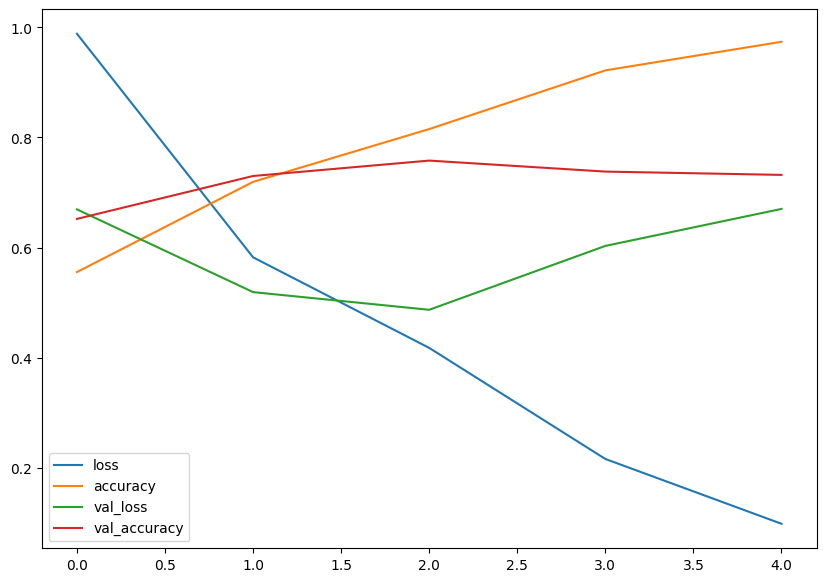

In [36]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7));

judging by <mark>our loss curves, it looks like our model is overfitting the training dataset. <mark>

🔑 Note: When a <mark>model's validation loss starts to increase, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset too well and thus its ability to generalize to unseen data will be diminished. <mark>

To further inspect our model's training performance, let's separate the accuracy and loss curves.

In [37]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

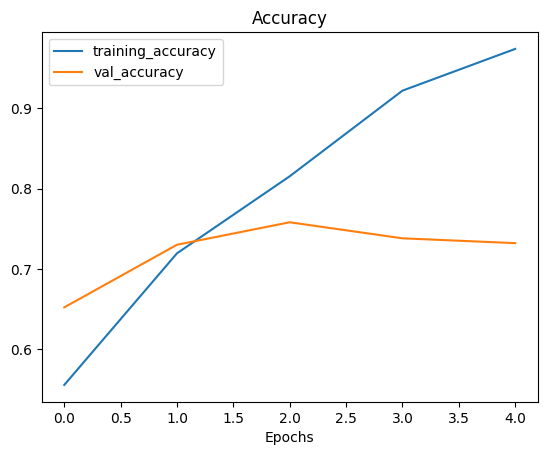

In [38]:
# Check out the loss curves of model_4
plot_loss_curves(history_4)

In [39]:
# Check out our model's architecture
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
